In [3]:
import cv2
import base64
import datetime
import glob
import numpy as np
import os
import time
import traceback
import concurrent.futures


In [4]:
class Matchers:
    def __init__(self):
        # self.surf = cv2.xfeatures2d.SURF_create()
        self.sift = cv2.SIFT_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)

    def cylindrical_warp(self, img):
        """ Warp an image onto a cylinder. """
        h, w = img.shape[:2]
        # Assume K is the camera matrix
        f = self.K[0, 0]  # focal length is usually the (1,1) element of the camera matrix

        # Define the cylindrical coordinates
        cylinder = np.zeros_like(img)
        cylinder_x = np.linspace(-w / 2, w / 2, w)
        cylinder_y = np.linspace(-h / 2, h / 2, h)
        cylinder_x, cylinder_y = np.meshgrid(cylinder_x, cylinder_y)

        # Convert (x, y) on the cylinder to (x', y') on the original image
        theta = cylinder_x / f
        h = cylinder_y / f
        x_new = f * np.tan(theta) + w / 2
        y_new = f * h / np.cos(theta) + h / 2

        # Ensure coordinates are within image bounds
        x_new = np.clip(x_new, 0, w - 1)
        y_new = np.clip(y_new, 0, h - 1)

        # Map the original image onto the cylinder
        cylinder = cv2.remap(img, x_new.astype(np.float32), y_new.astype(np.float32), cv2.INTER_LINEAR)
        
        return cylinder

    def match(self, i1, i2, direction=None):
        # i1_cyl = self.cylindrical_warp(i1, self.K)
        # i2_cyl = self.cylindrical_warp(i2, self.K)
        imageSet1 = self.getSIFTFeatures(i1)
        imageSet2 = self.getSIFTFeatures(i2)
        print("Direction : ", direction)
        matches = self.flann.knnMatch(
            imageSet2['des'],
            imageSet1['des'],
            k=2
            )
        good = []
        for i , (m, n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good.append((m.trainIdx, m.queryIdx))

        if len(good) > 4:
            pointsCurrent = imageSet2['kp']
            pointsPrevious = imageSet1['kp']

            matchedPointsCurrent = np.float32(
                [pointsCurrent[i].pt for (__, i) in good]
            )
            matchedPointsPrev = np.float32(
                [pointsPrevious[i].pt for (i, __) in good]
                )

            H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
            return H
        return None

    def getSIFTFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.sift.detectAndCompute(gray, None)
        return {'kp':kp, 'des':des}


In [5]:
class Stitch1:
    def __init__(self, imgs):
        self.images = imgs
        self.count = len(self.images)
        self.left_list, self.right_list, self.center_im = [], [], None
        self.matcher_obj = Matchers()
        self.prepare_lists()

    def prepare_lists(self):
        print("Number of images : %d"%self.count)
        self.centerIdx = self.count
        # print("Center index image : %d"%self.centerIdx)
        # self.center_im = self.images[int(self.centerIdx)]
        for i in range(self.count):
            if(i<=self.centerIdx):
                self.left_list.append(self.images[i])
            else:
                self.right_list.append(self.images[i])
        print("Image lists prepared")

    def leftshift(self):
        # self.left_list.reverse()
        a = self.left_list[0]
        try:
            for b in self.left_list[1:]:
                H = self.matcher_obj.match(a, b, 'left')
                # print("Homography is : ", H)
                if H is None:
                    break
                xh = np.linalg.inv(H)
                # print("Inverse Homography :", xh)
                ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
                ds = ds/ds[-1]
                # print("final ds=>", ds)
                f1 = np.dot(xh, np.array([0,0,1]))
                print(":::f1", f1)
                f1 = f1/f1[-1]

                xh[0][-1] += abs(f1[0])
                xh[1][-1] += abs(f1[1])
                # ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))

                offsety = abs(int(f1[1]))
                offsetx = abs(int(f1[0]))
                required_x = offsetx + b.shape[1]
                required_y = offsety + b.shape[0]
                dsize = (max(int(ds[0])+offsetx, required_x), max(int(ds[1]) + offsety, required_y))

                # dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
                print("image dsize =>", dsize)
                tmp = cv2.warpPerspective(a, xh, dsize)
                # cv2.imshow("warped", tmp)
                # cv2.waitKey()
                # print(":::Offset X:", offsetx, "Offset Y:", offsety)
                # print(":::Base image shape:", a.shape)
                # print(":::Transformed image shape:", tmp.shape)
                # print(":::Sub-image to insert shape:", b.shape)
                # print(":::Calculated destination slice:", (offsety, b.shape[0]+offsety), (offsetx, b.shape[1]+offsetx))

                tmp[offsety:(b.shape[0]+offsety), offsetx:(b.shape[1]+offsetx)] = b
                a = tmp
        except Exception:
            print("Image someeeee failed:::")
            print(traceback.format_exc())
            raise

        self.leftImage = a


    def rightshift(self):
        for each in self.right_list:
            H = self.matcher_obj.match(self.leftImage, each, 'right')
            print("Homography :", H)
            if H is None:
                continue
            txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
            txyz = txyz/txyz[-1]
            dsize = (int(txyz[0])+self.leftImage.shape[1], int(txyz[1])+self.leftImage.shape[0])
            tmp = cv2.warpPerspective(each, H, dsize)
            # cv2.imshow("tp", tmp)
            # cv2.waitKey()
            # tmp[:self.leftImage.shape[0], :self.leftImage.shape[1]]=self.leftImage
            tmp = self.mix_and_match(self.leftImage, tmp)
            print("tmp shape",tmp.shape)
            print("self.leftimage shape=", self.leftImage.shape)
            self.leftImage = tmp
        # self.showImage()



    def mix_and_match(self, leftImage, warpedImage):
        i1y, i1x = leftImage.shape[:2]
        i2y, i2x = warpedImage.shape[:2]
        print(leftImage[-1,-1])

        t = time.time()
        black_l = np.where(leftImage == np.array([0,0,0]))
        black_wi = np.where(warpedImage == np.array([0,0,0]))
        print(time.time() - t)
        print(black_l[-1])

        for i in range(0, i1x):
            for j in range(0, i1y):
                try:
                    if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
                        # print "BLACK"
                        # instead of just putting it with black, 
                        # take average of all nearby values and avg it.
                        warpedImage[j,i] = [0, 0, 0]
                    else:
                        if(np.array_equal(warpedImage[j,i],[0,0,0])):
                            # print "PIXEL"
                            warpedImage[j,i] = leftImage[j,i]
                        else:
                            if not np.array_equal(leftImage[j,i], [0,0,0]):
                                bw, gw, rw = warpedImage[j,i]
                                bl,gl,rl = leftImage[j,i]
                                # b = (bl+bw)/2
                                # g = (gl+gw)/2
                                # r = (rl+rw)/2
                                warpedImage[j, i] = [bl,gl,rl]
                except:
                    pass
        # cv2.imshow("waRPED mix", warpedImage)
        # cv2.waitKey()
        return warpedImage




    def trim_left(self):
        pass

    def showImage(self, string=None):
        # if string == 'left':
        cv2.imshow("left image", self.leftImage)
        #   # cv2.imshow("left image", cv2.resize(self.leftImage, (400,400)))
        # elif string == "right":
        #   cv2.imshow("right Image", self.rightImage)
        cv2.waitKey()

In [33]:
class Stitcher:

    def stitch(self, images, depths, ratio=0.75, reprojThresh=4.0, showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        res = images[0]
        depth_res = depths[0]
        for img, dep in zip(images[1:], depths[1:]):
            print("types", type(img), type(dep), type(res), type(depth_res))

            (kpsA, featuresA) = self.detectAndDescribe(res)
            (kpsB, featuresB) = self.detectAndDescribe(img)
            # match features between the two images
            M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
            # if the match is None, then there aren't enough matched
            # keypoints to create a panorama
            if M is None:
                break
                return None
            
            # otherwise, apply a perspective warp to stitch the images
            # together
            (matches, H, status) = M
            result = cv2.warpPerspective(
                img, H, (img.shape[1] + res.shape[1], max(img.shape[0], res.shape[0])),
                cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
            )
            depth_result = cv2.warpPerspective(
                dep, H, (dep.shape[1] + depth_res.shape[1], max(dep.shape[0], depth_res.shape[0])),
                cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
            )
            print(res.shape, result.shape, dep.shape, depth_result.shape)
            result[0:res.shape[0], 0:res.shape[1]] = res
            depth_result[0:depth_res.shape[0], 0:depth_res.shape[1]] = depth_res
            # check to see if the keypoint matches should be visualized
            result = self.remove_black_borders(result)
            depth_result = self.remove_black_borders(depth_result)
            # print(":::remove borders", type(result))
            if showMatches:
                vis = self.drawMatches(img, res, kpsA, kpsB, matches, status)
                # return a tuple of the stitched image and the
                # visualization
                cv2.imshow("VIZZZZZ", result)
                cv2.waitKey(0)

                return (result, vis)
            res = result
            depth_res = depth_result
            # return the stitched image
            # cv2.imshow("Result", result)
            # cv2.waitKey(0)
            # return result
        return res, depth_res
    
    def remove_black_borders(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        
        # Get the bounding rectangle for the largest contour
        x, y, w, h = cv2.boundingRect(max_contour)
        cropped_image = img[y:y+h, x:x+w]
        
        return cropped_image

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        # cv2.imshow("DETECTTT", image)
        # cv2.waitKey(0)
        print(":::typeeeee", type(image))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # detect keypoints in the image
        detector = cv2.SIFT_create()
        kps = detector.detect(gray)
        # extract features from the image
        (kps, features) = detector.compute(gray, kps)
        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])
        # return a tuple of keypoints and features
        return (kps, features)
    

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        # matcher = cv2.cuda.DescriptorMatcher_createBFMatcher(cv2.NORM_HAMMING)
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
        
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)
        # otherwise, no homograpy could be computed
        return None
    

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
        # return the visualization
        return vis


In [27]:
def get_images(path):
    imgs = []
    for img in sorted(glob.glob(path), key=os.path.getctime):
        # n = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY)
        n = cv2.imread(img)
        # n = imutils.resize(n, width=500)
        n = cv2.pyrDown(n)

        # Uncomment below lines based on the orientation of the camera
        imgs.append(np.rot90(n, k=3))
        # imgs.append(n)
    print("num_images", len(imgs))
    # import pdb
    # pdb.set_trace()
    return imgs

In [55]:
# img7, img8 = cv2.imread('.\Imgs\good\\0_test\img_0.jpeg'), cv2.imread('.\Imgs\good\\0_test\img_0.jpeg')
imgs = get_images('.\Imgs\good\\0_test\*')
depths = get_images('.\Imgs\good\\depth\*')

num_images 19
num_images 19


In [61]:
stitcher_cv = cv2.Stitcher.create()
status1, pano_img = stitcher_cv.stitch(imgs)
status2, pano_dep = stitcher_cv.stitch(depths)

In [58]:
status1

3

In [43]:
st = Stitcher()

yo, yo_depth = st.stitch(imgs,depths)

types <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
(960, 600, 3) (960, 1200, 3) (960, 600, 3) (960, 1200, 3)
types <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
(602, 601, 3) (960, 1201, 3) (960, 600, 3) (960, 1201, 3)
types <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
(787, 602, 3) (960, 1202, 3) (960, 600, 3) (960, 1202, 3)
types <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
:::typeeeee <class 'numpy.ndarray'>
(787, 602, 3) (960, 1202, 3) (960, 600, 3) (960, 1202, 3)
types <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndar

TypeError: Image data of dtype object cannot be converted to float

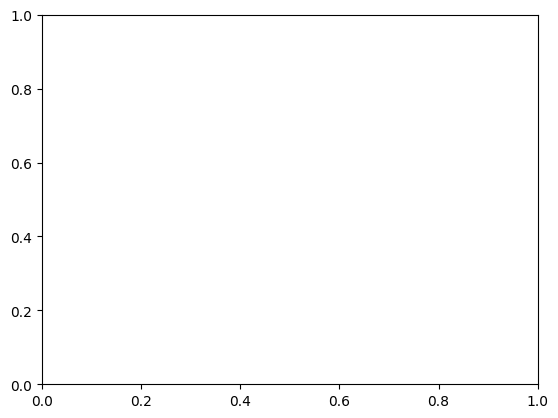

In [60]:
import matplotlib.pyplot as plt
plt.imshow(pano_dep,aspect="auto")
plt.show()

In [48]:
yo.shape

(960, 602, 3)

In [15]:
import glob
from PIL import Image
for file in glob.glob(".\Imgs\good\\depth\*"):
    src_im = Image.open(file)
    src_im.rotate(90).save(file)